In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import zipfile
import os
from tqdm import tqdm

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [3]:
path = "/kaggle/input/plantvillage-dataset/color"

In [4]:
# Loop through each class folder
for class_name in sorted(os.listdir(path)):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        # Count only files (ignore subfolders, if any)
        image_count = sum(
            1 for file in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, file))
        )
        print(f"{class_name}: {image_count} images")

Apple___Apple_scab: 630 images
Apple___Black_rot: 621 images
Apple___Cedar_apple_rust: 275 images
Apple___healthy: 1645 images
Blueberry___healthy: 1502 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Cherry_(including_sour)___healthy: 854 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Corn_(maize)___healthy: 1162 images
Grape___Black_rot: 1180 images
Grape___Esca_(Black_Measles): 1383 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Grape___healthy: 423 images
Orange___Haunglongbing_(Citrus_greening): 5507 images
Peach___Bacterial_spot: 2297 images
Peach___healthy: 360 images
Pepper,_bell___Bacterial_spot: 997 images
Pepper,_bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images
Raspberry___healthy: 371 images
Soybean___healthy: 5090 images
Squash___Powdery_mildew: 1835 images
S

In [5]:
import os
import shutil
import random
from pathlib import Path


random.seed(42)


source_dir = '/kaggle/input/plantvillage-dataset/color'
dest_dir   = '/kaggle/working/plantvillage-balanced'
min_required = 350


os.makedirs(dest_dir, exist_ok=True)


class_counts = {}
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)

print("Found classes:", len(class_counts))
print("Counts per class:", class_counts)


kept, skipped = [], []
for class_name, count in class_counts.items():
    src_class_path = os.path.join(source_dir, class_name)
    dst_class_path = os.path.join(dest_dir, class_name)

   
    if count < min_required:
        skipped.append((class_name, count))
        continue

    os.makedirs(dst_class_path, exist_ok=True)

    
    image_files = [f for f in os.listdir(src_class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

   
    sampled_files = random.sample(image_files, min_required)

    for filename in sampled_files:
        src = os.path.join(src_class_path, filename)
        dst = os.path.join(dst_class_path, filename)
        shutil.copy2(src, dst)

    kept.append((class_name, min_required))

print("\nSummary")
print("---------")
print(f"Kept classes (exactly {min_required} each): {len(kept)}")
for name, cnt in kept:
    print(f"  - {name}: {cnt}")

print(f"\nSkipped classes (< {min_required} images): {len(skipped)}")
for name, cnt in skipped:
    print(f"  - {name}: {cnt}")

print("\nBalanced dataset created at:", dest_dir)

Found classes: 38
Counts per class: {'Tomato___Late_blight': 1909, 'Tomato___healthy': 1591, 'Grape___healthy': 423, 'Orange___Haunglongbing_(Citrus_greening)': 5507, 'Soybean___healthy': 5090, 'Squash___Powdery_mildew': 1835, 'Potato___healthy': 152, 'Corn_(maize)___Northern_Leaf_Blight': 985, 'Tomato___Early_blight': 1000, 'Tomato___Septoria_leaf_spot': 1771, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 513, 'Strawberry___Leaf_scorch': 1109, 'Peach___healthy': 360, 'Apple___Apple_scab': 630, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5357, 'Tomato___Bacterial_spot': 2127, 'Apple___Black_rot': 621, 'Blueberry___healthy': 1502, 'Cherry_(including_sour)___Powdery_mildew': 1052, 'Peach___Bacterial_spot': 2297, 'Apple___Cedar_apple_rust': 275, 'Tomato___Target_Spot': 1404, 'Pepper,_bell___healthy': 1478, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076, 'Potato___Late_blight': 1000, 'Tomato___Tomato_mosaic_virus': 373, 'Strawberry___healthy': 456, 'Apple___healthy': 1645, 'Grape

In [6]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),     
    transforms.RandomHorizontalFlip(),      
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


dataset = datasets.ImageFolder(root="/kaggle/working/plantvillage-balanced", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])



val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes
num_classes = len(class_names)

In [7]:
class_names = dataset.classes
num_classes = len(class_names)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# FIX: Subset -> access underlying dataset
class_names = train_dataset.dataset.classes
total_class = len(class_names)

learning_rate = 0.0001

model = models.resnet50(pretrained=True)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace head
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, total_class)

model = model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [9]:
class EarlyStopping:

    def __init__(self, patience=5):

        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [10]:
from time import perf_counter
from tqdm import tqdm  
from torch.cuda.amp import autocast, GradScaler  
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim

num_epochs = 50  

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  

early_stopping = EarlyStopping(patience=5)  
train_losses, val_losses = [], []  

scaler = GradScaler()

total_train_t0 = perf_counter()
epoch_times = []

for epoch in range(num_epochs):
    t_epoch0 = perf_counter()
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast(enabled=(device.type == "cuda")):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            with autocast(enabled=(device.type == "cuda")):
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    t_epoch1 = perf_counter()
    epoch_times.append(t_epoch1 - t_epoch0)
    print(f"Epoch {epoch+1} time: {epoch_times[-1]:.2f} s")

    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break

total_train_t1 = perf_counter()
total_training_time_s = total_train_t1 - total_train_t0
avg_epoch_time_s = (sum(epoch_times)/len(epoch_times)) if epoch_times else float('nan')

print(f"\nTotal training time: {total_training_time_s:.2f} s")
print(f"Average per-epoch time: {avg_epoch_time_s:.2f} s")


/tmp/ipykernel_19/3201730471.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_19/3201730471.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
Validation:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_19/3201730471.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Train Loss: 1.1734, Validation Loss: 0.4352
Epoch 1 time: 41.52 s
Epoch 2/50


Train Loss: 0.3870, Validation Loss: 0.2918
Epoch 2 time: 41.11 s
Epoch 3/50


Train Loss: 0.2900, Validation Loss: 0.3055
Epoch 3 time: 41.13 s
Epoch 4/50


Train Loss: 0.2269, Validation Loss: 0.2327
Epoch 4 time: 40.97 s
Epoch 5/50


Train Loss: 0.1928, Validation Loss: 0.2008
Epoch 5 time: 41.12 s
Epoch 6/50


Train Loss: 0.1670, Validation Loss: 0.1713
Epoch 6 time: 41.36 s
Epoch 7/50


Train Loss: 0.1555, Validation Loss: 0.2195
Epoch 7 time: 41.11 s
Epoch 8/50


Train Loss: 0.1395, Validation Loss: 0.1658
Epoch 8 time: 41.29 s
Epoch 9/50


Train Loss: 0.1257, Validation Loss: 0.1696
Epoch 9 time: 40.97 s
Epoch 10/50


Train Loss: 0.1176, Validation Loss: 0.1769
Epoch 10 time: 40.80 s
Epoch 11/50


Train Loss: 0.1065, Validation Loss: 0.1505
Epoch 11 time: 40.78 s
Epoch 12/50


Train Loss: 0.0909, Validation Loss: 0.1625
Epoch 12 time: 40.78 s
Epoch 13/50


Train Loss: 0.0947, Validation Loss: 0.1496
Epoch 13 time: 40.81 s
Epoch 14/50


Train Loss: 0.0899, Validation Loss: 0.1476
Epoch 14 time: 40.76 s
Epoch 15/50


Train Loss: 0.0855, Validation Loss: 0.1707
Epoch 15 time: 40.69 s
Epoch 16/50


Train Loss: 0.0823, Validation Loss: 0.1941
Epoch 16 time: 40.72 s
Epoch 17/50


Train Loss: 0.0819, Validation Loss: 0.1880
Epoch 17 time: 40.85 s
Epoch 18/50


Train Loss: 0.0743, Validation Loss: 0.1502
Epoch 18 time: 40.86 s
Epoch 19/50


Train Loss: 0.0723, Validation Loss: 0.1565
Epoch 19 time: 40.83 s
Early stopping triggered.

Total training time: 778.45 s
Average per-epoch time: 40.97 s


In [11]:

model_save_path = "resnet50_model.pth"  


torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to resnet50_model.pth


In [12]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        with autocast():
            outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n", report)


/tmp/ipykernel_19/2379966855.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Classification Report:
               precision    recall  f1-score   support

           0     0.8824    0.9740    0.9259        77
           1     0.9831    1.0000    0.9915        58
           2     1.0000    0.8933    0.9437        75
           3     0.9737    1.0000    0.9867        74
           4     0.9831    0.9831    0.9831        59
           5     0.9848    1.0000    0.9924        65
           6     0.9000    0.8873    0.8936        71
           7     0.9859    1.0000    0.9929        70
           8     0.8689    0.8833    0.8760        60
           9     1.0000    1.0000    1.0000        65
          10     1.0000    0.8636    0.9268        66
          11     0.8875    1.0000    0.9404        71
          12     0.9870    0.9870    0.9870        77
          13     1.0000    1.0000    1.0000        67
          14     1.0000    1.0000    1.0000        65
          15     0.9853    0.9710    0.9781        69
          16     1.0000    1.0000    1.0000        72
   

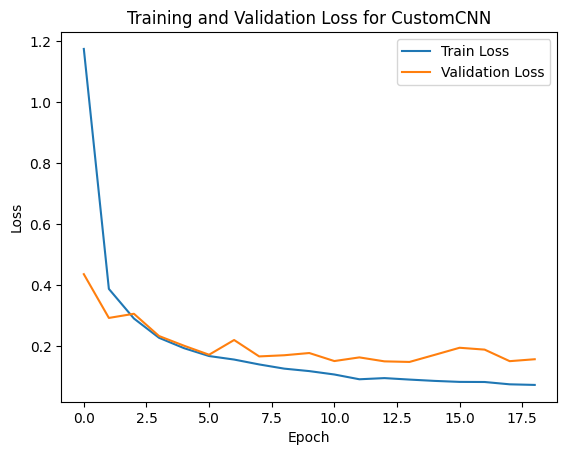

In [13]:
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for CustomCNN")
plt.show()

/tmp/ipykernel_19/1362086699.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Testing time: 4.39 sec  |  Throughput: 287.09 samples/sec
Confusion Matrix:
 [[33  0  0 ...  0  0  0]
 [ 0 32  0 ...  0  0  0]
 [ 1  0 36 ...  0  0  0]
 ...
 [ 0  0  0 ... 38  0  0]
 [ 0  0  0 ...  0 40  0]
 [ 0  0  0 ...  0  0 39]]

Confusion Matrix (row-normalized):
[[0.971 0.    0.    ... 0.    0.    0.   ]
 [0.    1.    0.    ... 0.    0.    0.   ]
 [0.025 0.    0.9   ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.95  0.    0.   ]
 [0.    0.    0.    ... 0.    0.93  0.   ]
 [0.    0.    0.    ... 0.    0.    0.951]]


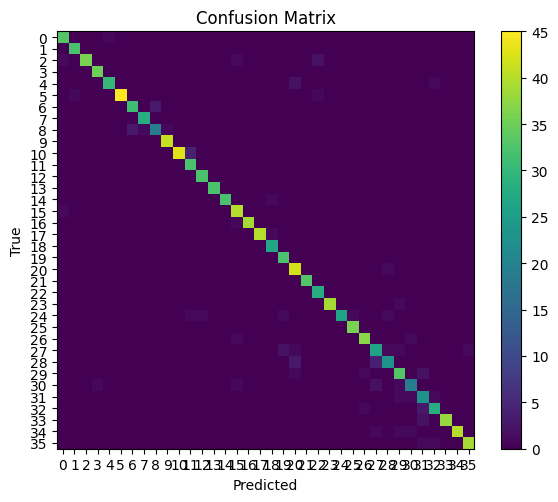

Per-class ROC AUC:
  Class 0: 0.9998
  Class 1: 1.0000
  Class 2: 0.9983
  Class 3: 1.0000
  Class 4: 0.9999
  Class 5: 0.9995
  Class 6: 0.9993
  Class 7: 1.0000
  Class 8: 0.9977
  Class 9: 1.0000
  Class 10: 0.9998
  Class 11: 0.9999
  Class 12: 1.0000
  Class 13: 1.0000
  Class 14: 0.9999
  Class 15: 0.9998
  Class 16: 1.0000
  Class 17: 0.9999
  Class 18: 0.9998
  Class 19: 1.0000
  Class 20: 0.9975
  Class 21: 1.0000
  Class 22: 0.9999
  Class 23: 1.0000
  Class 24: 1.0000
  Class 25: 1.0000
  Class 26: 0.9998
  Class 27: 0.9920
  Class 28: 0.9967
  Class 29: 0.9989
  Class 30: 0.9948
  Class 31: 0.9960
  Class 32: 0.9974
  Class 33: 0.9999
  Class 34: 0.9995
  Class 35: 0.9999
Micro-average ROC AUC: 0.9994
Macro-average ROC AUC: 0.9991


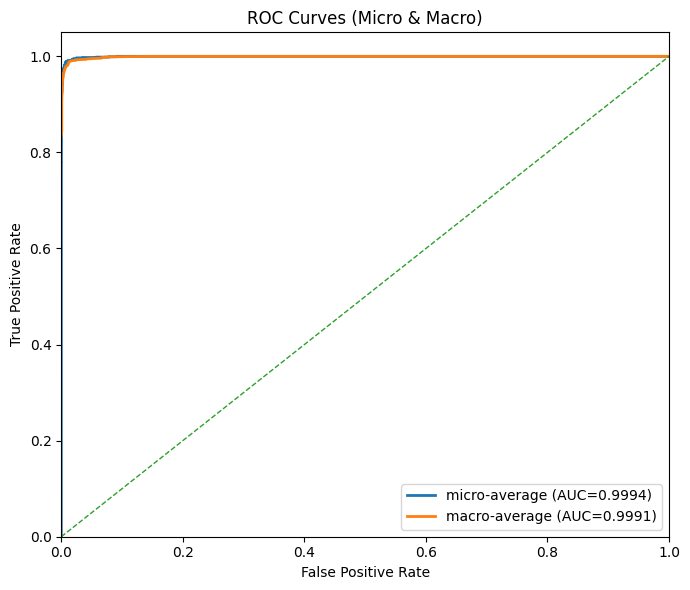

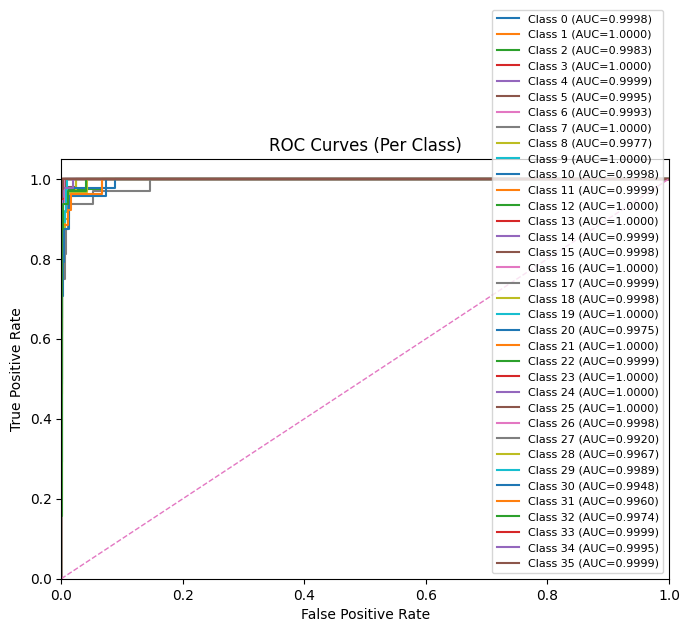


Classification Report (test):
              precision    recall  f1-score   support

           0     0.9429    0.9706    0.9565        34
           1     0.9697    1.0000    0.9846        32
           2     1.0000    0.9000    0.9474        40
           3     0.9722    1.0000    0.9859        35
           4     0.9677    0.9091    0.9375        33
           5     1.0000    0.9574    0.9783        47
           6     0.9118    0.9118    0.9118        34
           7     0.9655    1.0000    0.9825        28
           8     0.8636    0.7917    0.8261        24
           9     0.9762    1.0000    0.9880        41
          10     1.0000    0.9149    0.9556        47
          11     0.8649    1.0000    0.9275        32
          12     0.9697    1.0000    0.9846        32
          13     1.0000    1.0000    1.0000        32
          14     1.0000    0.9697    0.9846        33
          15     0.9091    0.9756    0.9412        41
          16     1.0000    0.9750    0.9873       

In [14]:
from time import perf_counter
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()

all_logits = []
all_probs = []
all_preds = []
all_labels = []

loader = test_loader

t_test_start = time.time()
with torch.no_grad():
    test_t0 = perf_counter()
    n_images_tested = 0
    for images, labels in loader:
        n_images_tested += images.size(0)
        images, labels = images.to(device), labels.to(device)
        with autocast(enabled=(device.type == "cuda")):
            logits = model(images)
            probs = F.softmax(logits, dim=1)

        preds = torch.argmax(probs, dim=1)

        all_logits.append(logits.detach().cpu().numpy())
        all_probs.append(probs.detach().cpu().numpy())
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

t_test_end = time.time()
total_test_time_sec = t_test_end - t_test_start
n_samples = len(all_preds)
print(f"Testing time: {total_test_time_sec:.2f} sec  |  Throughput: {n_samples/total_test_time_sec:.2f} samples/sec")

all_logits = np.concatenate(all_logits, axis=0)
all_probs = np.concatenate(all_probs, axis=0)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

num_classes = all_probs.shape[1]
class_indices = list(range(num_classes))

cm = confusion_matrix(all_labels, all_preds, labels=class_indices)
print("Confusion Matrix:\n", cm)

def print_cm(cm):
    row_sums = cm.sum(axis=1, keepdims=True).clip(min=1)
    norm_cm = cm / row_sums
    print("\nConfusion Matrix (row-normalized):")
    with np.printoptions(precision=3, suppress=True):
        print(norm_cm)

print_cm(cm)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

y_true_bin = label_binarize(all_labels, classes=class_indices) if num_classes > 2 else all_labels
y_score = all_probs

if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_true_bin, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    print(f"Binary ROC AUC: {roc_auc:.4f}")

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Binary)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
else:
    fpr = {}
    tpr = {}
    roc_auc = {}
    for c in class_indices:
        fpr[c], tpr[c], _ = roc_curve(y_true_bin[:, c], y_score[:, c])
        roc_auc[c] = auc(fpr[c], tpr[c])

    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in class_indices]))
    mean_tpr = np.zeros_like(all_fpr)
    for c in class_indices:
        mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print("Per-class ROC AUC:")
    for c in class_indices:
        print(f"  Class {c}: {roc_auc[c]:.4f}")
    print(f"Micro-average ROC AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average ROC AUC: {roc_auc['macro']:.4f}")

    plt.figure(figsize=(7, 6))
    plt.plot(fpr["micro"], tpr["micro"], lw=2, label=f'micro-average (AUC={roc_auc["micro"]:.4f})')
    plt.plot(fpr["macro"], tpr["macro"], lw=2, label=f'macro-average (AUC={roc_auc["macro"]:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Micro & Macro)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 6))
    for c in class_indices:
        plt.plot(fpr[c], tpr[c], lw=1.5, label=f'Class {c} (AUC={roc_auc[c]:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Per Class)')
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    plt.show()

print("\nClassification Report (test):")
print(classification_report(all_labels, all_preds, digits=4))

test_t1 = perf_counter()
total_test_time_s = test_t1 - test_t0
avg_per_image_ms = (total_test_time_s / max(1, n_images_tested)) * 1000.0
print(f"\nTotal test inference time: {total_test_time_s:.2f} s for {n_images_tested} images")
print(f"Average per-image inference time: {avg_per_image_ms:.2f} ms")

In [15]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-580yuhwd
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-580yuhwd
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3

In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

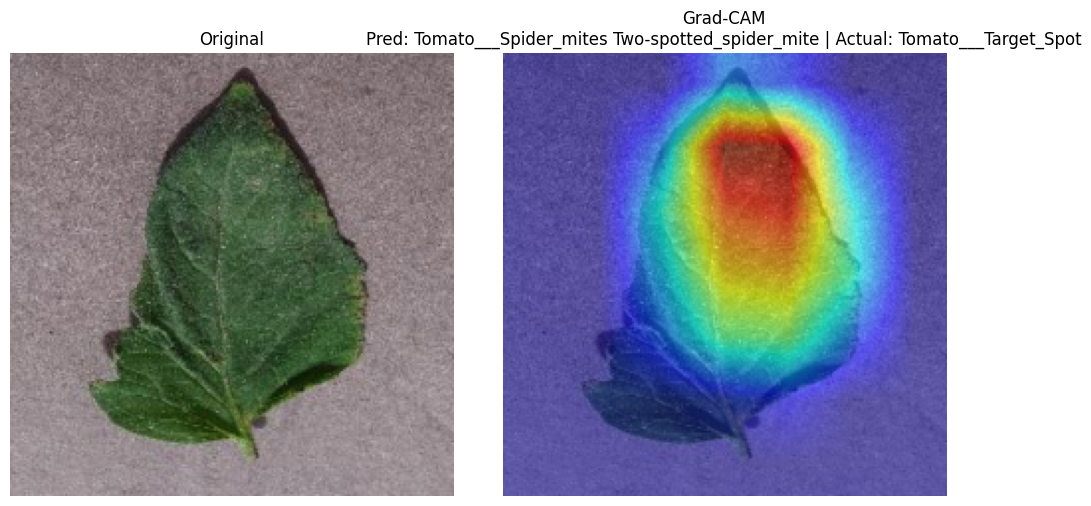

In [17]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)


for p in model.layer4.parameters():
    p.requires_grad_(True)


sample_image, label = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to(device)


original_image_np = sample_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
original_image_np = (original_image_np * 0.5) + 0.5 
original_image_np = original_image_np.clip(0, 1)


target_layers = [model.layer4[-1]]


cam = GradCAM(model=model, target_layers=target_layers)


outputs = model(sample_image)
predicted_class = outputs.argmax(dim=1).item()


targets = [ClassifierOutputTarget(predicted_class)]


grayscale_cam = cam(input_tensor=sample_image, targets=targets, eigen_smooth=True)
heatmap = grayscale_cam[0]


result = show_cam_on_image(original_image_np, heatmap, use_rgb=True)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original_image_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM\nPred: {class_names[predicted_class]} | Actual: {class_names[label]}")
plt.imshow(result)
plt.axis('off')

plt.tight_layout()
plt.show()


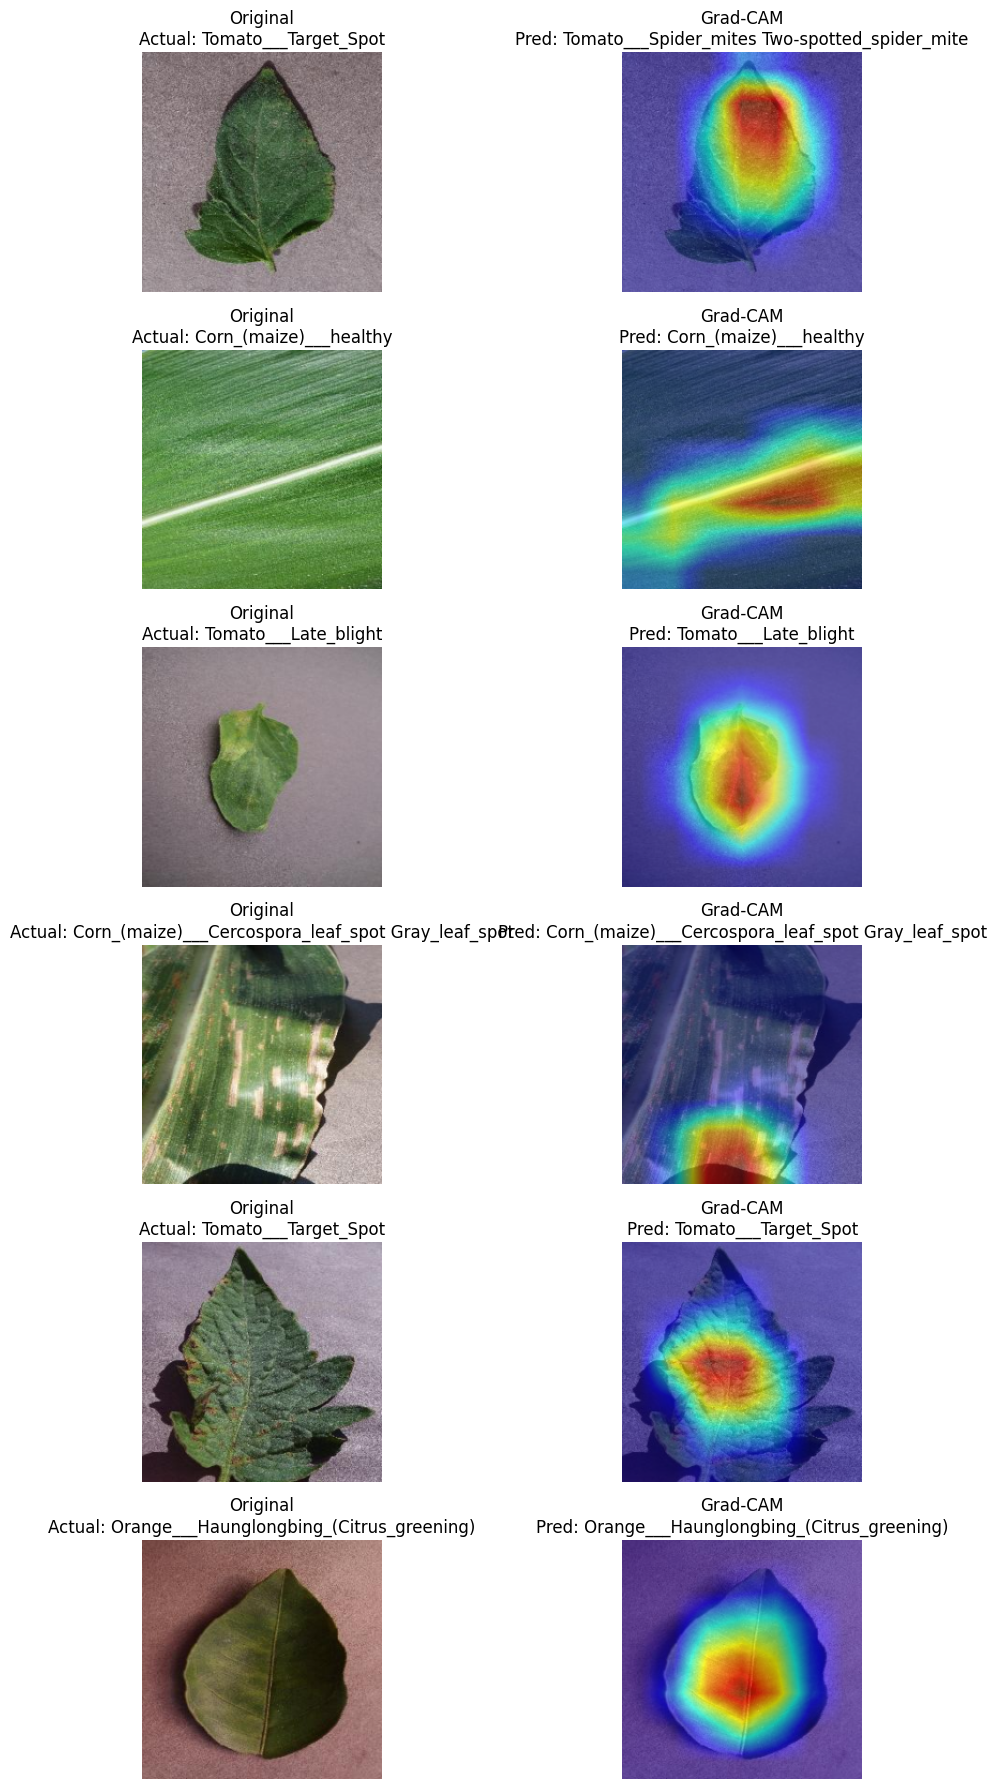

In [18]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import torch
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)


for p in model.layer4.parameters():
    p.requires_grad_(True)


target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)


num_images_to_show = 6  
rows = num_images_to_show
cols = 2 

plt.figure(figsize=(12, rows * 3))

for i in range(num_images_to_show):
    img_t, label = test_dataset[i]
    x = img_t.unsqueeze(0).to(device)

  
    orig = img_t.permute(1,2,0).cpu().numpy()
    orig = (orig * 0.5) + 0.5
    orig = orig.clip(0, 1)

   
    outputs = model(x)
    pred = outputs.argmax(dim=1).item()
    targets = [ClassifierOutputTarget(pred)]
    grayscale_cam = cam(input_tensor=x, targets=targets, eigen_smooth=True)
    heatmap = grayscale_cam[0]
    overlay = show_cam_on_image(orig, heatmap, use_rgb=True)

    
    plt.subplot(rows, cols, i*cols + 1)
    plt.imshow(orig); plt.axis('off')
    plt.title(f"Original\nActual: {class_names[label]}")


    plt.subplot(rows, cols, i*cols + 2)
    plt.imshow(overlay); plt.axis('off')
    plt.title(f"Grad-CAM\nPred: {class_names[pred]}")

plt.tight_layout()
plt.show()